# Titanic Machine Learning
All aboard the Titanic... will you be one of the lucky ones that survives? In this machine learning exercise, I intend to find out. I'm using the standard [Kaggle Titanic dataset](https://www.kaggle.com/c/titanic) to practice using a classifier.

This notebook is organized as follows:
- Preliminary Data Analysis
- Further Data Cleaning
    - Age
    - Port of Embarkment
    - Cabin
- Further Data Analysis
    - Useful Functions
    - Age
    - Passenger Class
    - Siblings and Spouses
    - Parents and Children
    - Port of Embarkment
    - Summary

## Exploratory Data Analysis

In [132]:
# Load in the libraries we'll need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [51]:
# Global constants
FIG_WIDTH_INCHES = 5
FIG_HEIGHT_INCHES = 5
LABEL_SIZE_POINT = 12
TICK_LABEL_SIZE_POINT = 11
TITLE_SIZE_POINT = 14
TITANIC_COLOUR = "#31343F"
SURVIVED_COLOUR = "#86BD8A"
DID_NOT_SURVIVE_COLOUR = "#BF6060"

In [3]:
# Display options

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [4]:
# Load titanic data
def load_titanic_data():
    train= pd.read_csv('./train.csv')
    test = pd.read_csv('./test.csv')
    return [train, test]

In [5]:
train_data = load_titanic_data()[0]
test_data = load_titanic_data()[1]

In [6]:
# Peruse the data
train_data.head(25)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


We notice that there some missing ages, and that the cabin information is missing a lot. Use the `info()` method to get an idea of how complete the data is.

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Let's look at how the variables are correlated.

In [8]:
train_data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


Among the numerical variables, the Survived variable is most strongly correlated with the Pclass and the Fare variable. We expect this: the lower the passenger's class number the more likely they are to survive (e.g. First class passengers are more likely to survive than third class). The more a passenger paid for their ticket, the more likely they are to survive. Overall, nothing mysterious here.

Overall, this is a clean data set apart from the Cabin variable and a few missing ages. Oddly enough, there are a couple people who's port of embarkment is not known. Let's deal with these.

## Further Data Cleaning
## Age
Get the mean age by gender fill any NaNs for age with the appropriate mean value. For example, if a woman's age is missing, replace it with the mean age of all women aboard the Titanic.

There are more complicated imputations: we could account for passenger class, but let's keep it simple for now.

In [9]:
# Get unique gender values
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [10]:
# Get the mean age of men and women
age_by_gender = train_data[
    [
        "Sex",
        "Age"
    ]
].groupby("Sex").agg(
    {
        "Age": "mean"
    }
)
age_by_gender

,Age
Sex,
female,27.915709
male,30.726645


Males on the titanic, on average, were older than women.

In [11]:
# Impute the missing ages. Drop this into a function so we can re-use it on the test data.
train_data.loc[
    (
        train_data["Sex"] == "male"
    )
    & (
        pd.isna(train_data["Age"])
    ),
    "Age"
] = age_by_gender.loc[
    "male",
    "Age"
]

train_data.loc[
    (
        train_data["Sex"] == "female"
    )
    & (
        pd.isna(train_data["Age"])
    ),
    "Age"
] = age_by_gender.loc[
    "female",
    "Age"
]

In [12]:
# Check that there are no more missing Age values.
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Port of Embarkment
Let's see what are the two records whose port of embarkents aren't known.

In [13]:
train_data[
    pd.isna(train_data["Embarked"])
]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Looking up these passengers, it seems that [Miss Amelie Icard](https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html) embarked at Southampton, and [Mrs. Martha Evelyn Stone](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html) embarked at Southampton. Fill in these values.

In [14]:
# Since both passengers embarked at Southampton, just set the missing values to "S".
train_data.loc[
    pd.isna(train_data["Embarked"]),
    "Embarked"
] = "S"

In [15]:
# Check that we've fixed our missing values
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Cabin
This one is trickier. There are 687 missing values. We *could* go through and find the info for each missing passenger and fix each record. But let's see if we can be smarter, and get away without using this feature. But this isn't necessarily even possible. For example [Mr. Owen Harris Braund](https://www.encyclopedia-titanica.org/titanic-victim/owen-harris-braund.html)'s cabin information is missing, yet his cabin doesn't seem to be known.

In [16]:
train_data.loc[
    pd.isna(train_data["Cabin"])
]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,30.726645,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.000000,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.000000,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,27.915709,1,2,W./C. 6607,23.4500,NaN,S


In [17]:
# Take a look at the unique cabin values
train_data["Cabin"].value_counts()

G6             4
B96 B98        4
C23 C25 C27    4
F33            3
C22 C26        3
              ..
B71            1
D7             1
E34            1
B4             1
E10            1
Name: Cabin, Length: 147, dtype: int64

This doesn't seem to help us. For now, we'll leave the Cabin feature as it is, and just leave it unused in the classification.

## Further Data Analysis
Let's have some fun and make some charts.
### Useful Functions

In [84]:
# Define a plot histogram function
def plot_histogram(
    axis, # matplotlib axis object
    data_frame, # data frame of which we want a histogram of one columns
    data_column_string, # the string that identifies the column in data_frame we want to visualize
    bins_list, # a list of the bins we want to use. Make sure this is a list.
    colour_string, # A colour, as a hex code (as a string), for the colour of the bars in the histogram
    xlabel_string, # String of the x-axis label
    ylabel_string, # String of the y-axis label
    title_string, # String of the title
    label_size_num=12, # Size of the x- and y-labels
    title_size_num=14, # Size of the title
    tick_label_size_num=11, # Size of the x- and y-tick labels
    padding_num=20, # Padding of the titles and labels
    edge_colour_string="w", # Colour, as a hex code (as a string), for the edge colour of the bars.
    linewidth_num=1, # Size of the edges outlining the bars, in points
    alignment_string="mid", # With "mid" bars are centred between bin edges. Try "left" or "right"
    density_flag=False # Plot a probability density function?
):
    [bins, values, patches] = axis.hist(
        x=data_frame[
            data_column_string
        ],
        bins=bins_list,
        color=colour_string,
        edgecolor=edge_colour_string,
        linewidth=linewidth_num,
        density=density_flag,
        align=alignment_string
    )
    
    # Set x- and y-labels and title
    axis.set_xlabel(
        xlabel_string,
        size=label_size_num,
        labelpad=padding_num
    )
    axis.set_ylabel(
        ylabel_string,
        size=label_size_num,
        labelpad=padding_num
    )
    axis.set_title(
        title_string,
        size=title_size_num,
        pad=padding_num
    )
    
    # Set x- and y-ticklabel sizes
    for x in axis.get_xticklabels():
        x.set_size(tick_label_size_num)

    for y in axis.get_yticklabels():
        y.set_size(tick_label_size_num)
        
    return [bins, values, patches]


### Age
Age is a continuous variable, so let's make a histogram of it.

In [124]:
# Get the minimum and maximum of the training data
train_data["Age"].describe()

count    891.000000
mean      29.736034
std       13.014897
min        0.420000
25%       22.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

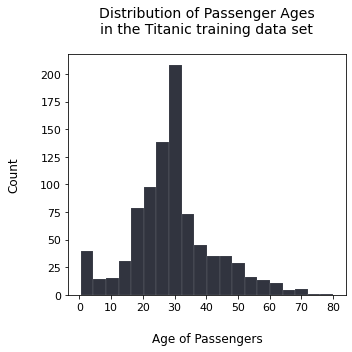

In [78]:
fig = plt.figure(
    figsize=(
        FIG_WIDTH_INCHES,
        FIG_HEIGHT_INCHES
    )
)
ax = fig.add_subplot(111)
plot_histogram(
    axis=ax,
    data_frame=train_data,
    data_column_string="Age",
    bins_list=20,
    colour_string=TITANIC_COLOUR,
    xlabel_string="Age of Passengers",
    ylabel_string="Count",
    title_string="Distribution of Passenger Ages\nin the Titanic training data set",
    linewidth_num=0.1,
)
plt.tight_layout()
plt.show()

There are some children (ages zero to ten), lots of people aged about 18 to 40, and some people aged 40 and above. We remark a spike at about 27 and 30. Plot the histogram for age, but this time, for passengers who died and who didn't.

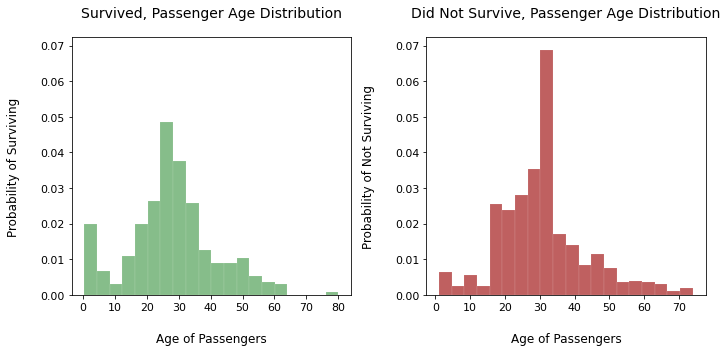

In [80]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(
    FIG_WIDTH_INCHES * 2, 
    FIG_HEIGHT_INCHES
)
plot_histogram(
    axis=ax1,
    data_frame=train_data[
        train_data["Survived"]==1
    ],
    data_column_string="Age",
    bins_list=20,
    colour_string=SURVIVED_COLOUR,
    xlabel_string="Age of Passengers",
    ylabel_string="Probability of Surviving",
    title_string="Survived, Passenger Age Distribution",
    linewidth_num=0.1,
    density_flag=True
)

plot_histogram(
    axis=ax2,
    data_frame=train_data[
        train_data["Survived"]==0
    ],
    data_column_string="Age",
    bins_list=20,
    colour_string=DID_NOT_SURVIVE_COLOUR,
    xlabel_string="Age of Passengers",
    ylabel_string="Probability of Not Surviving",
    title_string="Did Not Survive, Passenger Age Distribution",
    linewidth_num=0.1,
    density_flag=True
)

# Adjust the x-limits on the first plot to match that of the second
ax1.set_ylim(
    ax2.get_ylim()
)
plt.tight_layout()
plt.show()

We see a lot of 30 year olds perished, as did a lot of people aged about 20-30. We see a lot of 25 and 30 year olds also survived. Among the survivors, children (age 0 to 10) represent a larger fraction of the population that survived as opposed to the population that perished. This makes sense, as we'd expect people to try to save children. We also remark that more people aged (approximately) 23 to 26 survived, and a lot of people aged 30 to 33 perished. This sort of hints that more women (mean aged 28) survived than did men (mean aged 31).

This suggests that age is a determinant of a passenger's survival.

### Passenger Class

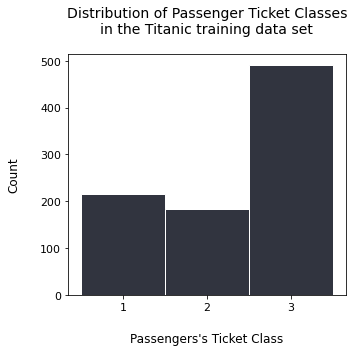

In [87]:
# Plot the distribution of passenger class
fig = plt.figure(
    figsize=(
        FIG_WIDTH_INCHES,
        FIG_HEIGHT_INCHES
    )
)
ax = fig.add_subplot(111)
plot_histogram(
    axis=ax,
    data_frame=train_data,
    data_column_string="Pclass",
    bins_list=[1, 2, 3, 4],
    colour_string=TITANIC_COLOUR,
    xlabel_string="Passengers's Ticket Class",
    ylabel_string="Count",
    title_string="Distribution of Passenger Ticket Classes\nin the Titanic training data set",
    linewidth_num=1,
    alignment_string="left"
)
ax.set_xticks([1, 2, 3])
plt.tight_layout()
plt.show()

There were significantly more third class passengers than first or second class passengers. Let's take a look at the distribution of passenger class among the population that survived, and that, which didn't.

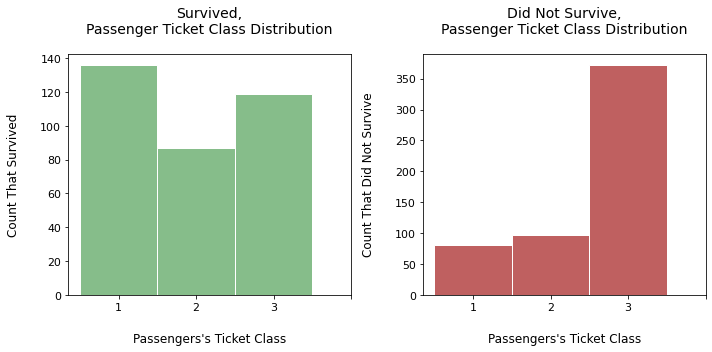

In [118]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(
    FIG_WIDTH_INCHES * 2, 
    FIG_HEIGHT_INCHES
)
# Define a bin list for classes 1, 2, 3
bin_list = [1, 2, 3, 4]
plot_histogram(
    axis=ax1,
    data_frame=train_data[
        train_data["Survived"]==1
    ],
    data_column_string="Pclass",
    bins_list=[1, 2, 3, 4],
    colour_string=SURVIVED_COLOUR,
    xlabel_string="Passengers's Ticket Class",
    ylabel_string="Count That Survived",
    title_string="Survived,\nPassenger Ticket Class Distribution",
    linewidth_num=1,
    alignment_string="left"
)

plot_histogram(
    axis=ax2,
    data_frame=train_data[
        train_data["Survived"]==0
    ],
    data_column_string="Pclass",
    bins_list=[1, 2, 3, 4],
    colour_string=DID_NOT_SURVIVE_COLOUR,
    xlabel_string="Passengers's Ticket Class",
    ylabel_string="Count That Did Not Survive",
    title_string="Did Not Survive,\nPassenger Ticket Class Distribution",
    linewidth_num=1,
    alignment_string="left"
)

# Adjust the x-ticks and x-ticklabels to have only passenger class 1, 2, 3
ax1.set_xticks(bin_list)
ax2.set_xticks(bin_list)
ax1.set_xticklabels([1, 2, 3, None])
ax2.set_xticklabels([1, 2, 3, None])
plt.tight_layout()
plt.show()

Clearly, ticket class is a determinant of surviving. Being in third class means you were much more likely to perish than being in first or second class. Being in first class meant you were most likely to survive.

Passenger class is a determinant of passenger survival.

### Siblings and Spouses
The feature SibSp represents the number of siblings or spouses aboard the Titanic.

In [111]:
train_data["SibSp"].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

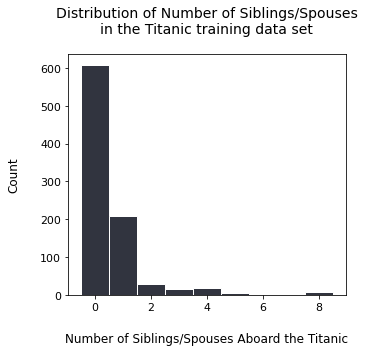

In [112]:
# Plot the distribution of SibSp
fig = plt.figure(
    figsize=(
        FIG_WIDTH_INCHES,
        FIG_HEIGHT_INCHES
    )
)
ax = fig.add_subplot(111)
plot_histogram(
    axis=ax,
    data_frame=train_data,
    data_column_string="SibSp",
    bins_list=list(np.arange(10)),
    colour_string=TITANIC_COLOUR,
    xlabel_string="Number of Siblings/Spouses Aboard the Titanic",
    ylabel_string="Count",
    title_string="Distribution of Number of Siblings/Spouses\nin the Titanic training data set",
    linewidth_num=1,
    alignment_string="left"
)
plt.tight_layout()
plt.show()

We see that the vast majority of passengers aboard the Titanic were single. About 200 people were travelling with one companion, and much fewer travelled with more than one companion. Let's examine the number of siblings and spouses among those who survived and those who perished.

In [113]:
train_data.loc[
    (train_data["Survived"]==0),
    "SibSp"
].value_counts()

0    398
1     97
2     15
4     15
3     12
8      7
5      5
Name: SibSp, dtype: int64

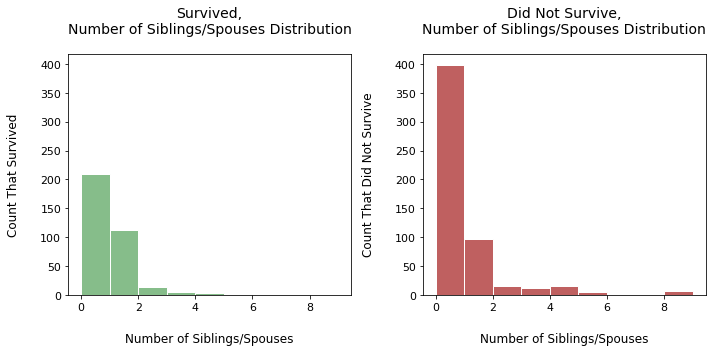

In [116]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(
    FIG_WIDTH_INCHES * 2, 
    FIG_HEIGHT_INCHES
)

bin_list = list(np.arange(10))
plot_histogram(
    axis=ax1,
    data_frame=train_data[
        train_data["Survived"]==1
    ],
    data_column_string="SibSp",
    bins_list=bin_list,
    colour_string=SURVIVED_COLOUR,
    xlabel_string="Number of Siblings/Spouses",
    ylabel_string="Count That Survived",
    title_string="Survived,\nNumber of Siblings/Spouses Distribution",
    linewidth_num=1,
)

plot_histogram(
    axis=ax2,
    data_frame=train_data[
        train_data["Survived"]==0
    ],
    data_column_string="SibSp",
    bins_list=bin_list,
    colour_string=DID_NOT_SURVIVE_COLOUR,
    xlabel_string="Number of Siblings/Spouses",
    ylabel_string="Count That Did Not Survive",
    title_string="Did Not Survive,\nNumber of Siblings/Spouses Distribution",
    linewidth_num=1,
)

# Adjust the x-limits on the first plot to match that of the second
ax1.set_ylim(
    ax2.get_ylim()
)
plt.tight_layout()
plt.show()

The distributions of the number of siblings/spouses for both the populations that survived and didn't survive seem similar. More single passengers survived thatn passengers travelliing with one or more companion. Travelling with more spouses/siblings correlates with not surviving.

The number of siblings/spouses is not as strong a determinant of survival as, say, ticket class.

### Sex

In [123]:
# (No need to visualize, as this is a binary variable.)
# Get a sense of how many men/women were aboard.
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [121]:
# How many men/women survived?
train_data.loc[
    (train_data["Survived"]==1),
    "Sex"
].value_counts()

female    233
male      109
Name: Sex, dtype: int64

In [122]:
# How many men/women perished?
train_data.loc[
    (train_data["Survived"]==0),
    "Sex"
].value_counts()

male      468
female     81
Name: Sex, dtype: int64

65% of passengers were male, and 35% were female. Of those that survived, 68% were female, while of those that perished, 85% were male.

Sex is a strong determinant of survival aboard the Titanic.

### Fare

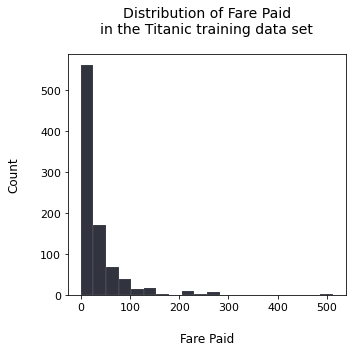

In [125]:
fig = plt.figure(
    figsize=(
        FIG_WIDTH_INCHES,
        FIG_HEIGHT_INCHES
    )
)
ax = fig.add_subplot(111)
plot_histogram(
    axis=ax,
    data_frame=train_data,
    data_column_string="Fare",
    bins_list=20,
    colour_string=TITANIC_COLOUR,
    xlabel_string="Fare Paid",
    ylabel_string="Count",
    title_string="Distribution of Fare Paid\nin the Titanic training data set",
    linewidth_num=0.1,
)
plt.tight_layout()
plt.show()

This suggests that most passengers paid less than (about) 25 pounds for their ticket. Let's examine the fare paid by the population that survived and the population that didn't survive.

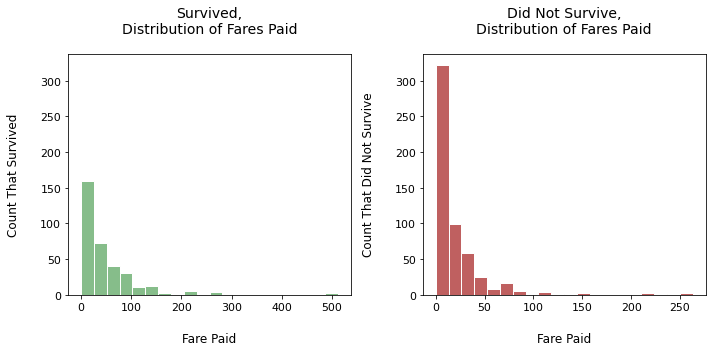

In [127]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(
    FIG_WIDTH_INCHES * 2, 
    FIG_HEIGHT_INCHES
)

bin_list = 20
plot_histogram(
    axis=ax1,
    data_frame=train_data[
        train_data["Survived"]==1
    ],
    data_column_string="Fare",
    bins_list=bin_list,
    colour_string=SURVIVED_COLOUR,
    xlabel_string="Fare Paid",
    ylabel_string="Count That Survived",
    title_string="Survived,\nDistribution of Fares Paid",
    linewidth_num=1,
)

plot_histogram(
    axis=ax2,
    data_frame=train_data[
        train_data["Survived"]==0
    ],
    data_column_string="Fare",
    bins_list=bin_list,
    colour_string=DID_NOT_SURVIVE_COLOUR,
    xlabel_string="Fare Paid",
    ylabel_string="Count That Did Not Survive",
    title_string="Did Not Survive,\nDistribution of Fares Paid",
    linewidth_num=1,
)

# Adjust the x-limits on the first plot to match that of the second
ax1.set_ylim(
    ax2.get_ylim()
)
plt.tight_layout()
plt.show()

Of those who paid 25 pounds or less, about 160 survived, while approximately 400 perished. In contast, of those that paid 270 pounds or more survived. However, there were still some who paid between 100 and 250 pounds that perished.

This suggests that the fare paid is a determinant of survival, but not as strong a determinant as passenger class.

### Parents and Children

In [134]:
train_data["Parch"].describe()

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

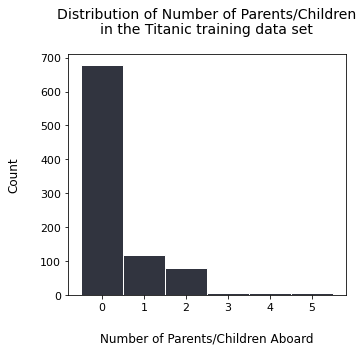

In [142]:
# Plot a histogram of the number of parents/children abord
fig = plt.figure(
    figsize=(
        FIG_WIDTH_INCHES,
        FIG_HEIGHT_INCHES
    )
)
ax = fig.add_subplot(111)
plot_histogram(
    axis=ax,
    data_frame=train_data,
    data_column_string="Parch",
    bins_list=list(np.arange(7)),
    colour_string=TITANIC_COLOUR,
    xlabel_string="Number of Parents/Children Aboard",
    ylabel_string="Count",
    title_string="Distribution of Number of Parents/Children\nin the Titanic training data set",
    linewidth_num=1,
    alignment_string="left"
)
plt.tight_layout()
plt.show()

The vast majority of people abord the Titanic did not have any parents or children. About 200 people had one or two parents/children aboard. Let's look at the number of parents/children in the populations that survived/didn't survive.

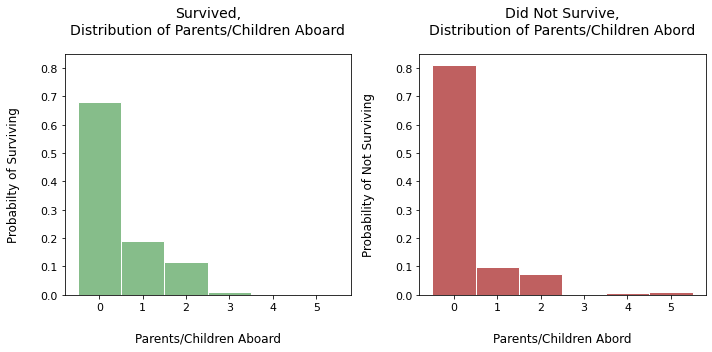

In [141]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(
    FIG_WIDTH_INCHES * 2, 
    FIG_HEIGHT_INCHES
)

bin_list = list(np.arange(7))
plot_histogram(
    axis=ax1,
    data_frame=train_data[
        train_data["Survived"]==1
    ],
    data_column_string="Parch",
    bins_list=bin_list,
    colour_string=SURVIVED_COLOUR,
    xlabel_string="Parents/Children Aboard",
    ylabel_string="Probabilty of Surviving",
    title_string="Survived,\nDistribution of Parents/Children Aboard",
    linewidth_num=1,
    alignment_string="left",
    density_flag=True
)

plot_histogram(
    axis=ax2,
    data_frame=train_data[
        train_data["Survived"]==0
    ],
    data_column_string="Parch",
    bins_list=bin_list,
    colour_string=DID_NOT_SURVIVE_COLOUR,
    xlabel_string="Parents/Children Abord",
    ylabel_string="Probability of Not Surviving",
    title_string="Did Not Survive,\nDistribution of Parents/Children Abord",
    linewidth_num=1,
    alignment_string="left",
    density_flag=True
)

# Adjust the x-limits on the first plot to match that of the second
ax1.set_ylim(
    ax2.get_ylim()
)
plt.tight_layout()
plt.show()

Passengers with one or two parents/children aboard had higher chances of survival. This conforms with what we know about the Titanic, that parents with children were prioritized in the lifeboats. However, it does seem that larger families seem to perish.

Parch is a determinant of survival on the Titanic.

### Port of Embarkment

In [161]:
train_data["Embarked"].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

[646. 168.  77.]
[0.         0.66666667 1.33333333 2.        ]


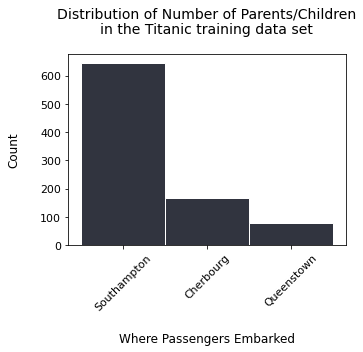

In [166]:
# Plot a histogram of the number of where people embarked
fig = plt.figure(
    figsize=(
        FIG_WIDTH_INCHES,
        FIG_HEIGHT_INCHES
    )
)
ax = fig.add_subplot(111)
[bins, labels, patches] = plot_histogram(
    axis=ax,
    data_frame=train_data,
    data_column_string="Embarked",
    bins_list=3,
    colour_string=TITANIC_COLOUR,
    xlabel_string="Where Passengers Embarked",
    ylabel_string="Count",
    title_string="Distribution of Number of Parents/Children\nin the Titanic training data set",
    linewidth_num=1,
    alignment_string="left"
)

# Take look at bins and labels
print(bins)
print(labels)

# The bin edges are 0, 2/3, 4/3, and 2
# The left edges of the bins are 0, 2/3, and 4/3.
# Re-set the x-ticklabels to these values and re-define the label
# Drop this into a little utility function
def correct_embarkment_labels(axis):
    axis.set_xticks(
        np.linspace(0, 4/3, 3)
    )
    axis.set_xticklabels(
        [
            "Southampton",
            "Cherbourg",
            "Queenstown"
        ]
    )

    # Rotate the labels
    for x in axis.get_xticklabels():
        x.set_rotation(45)

correct_embarkment_labels(ax)       
plt.tight_layout()
plt.show()

The vast majority of passengers got on at Southampton. Let's look at port of embarkment in the survived/did not survive populations.

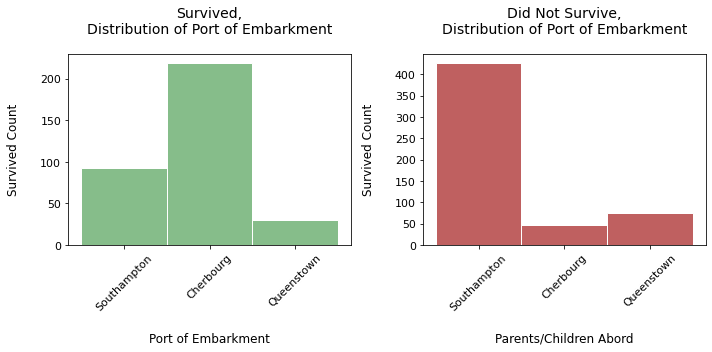

In [168]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(
    FIG_WIDTH_INCHES * 2, 
    FIG_HEIGHT_INCHES
)

bin_list = 3
plot_histogram(
    axis=ax1,
    data_frame=train_data[
        train_data["Survived"]==1
    ],
    data_column_string="Embarked",
    bins_list=bin_list,
    colour_string=SURVIVED_COLOUR,
    xlabel_string="Port of Embarkment",
    ylabel_string="Survived Count",
    title_string="Survived,\nDistribution of Port of Embarkment",
    linewidth_num=1,
    alignment_string="left",
)

plot_histogram(
    axis=ax2,
    data_frame=train_data[
        train_data["Survived"]==0
    ],
    data_column_string="Embarked",
    bins_list=bin_list,
    colour_string=DID_NOT_SURVIVE_COLOUR,
    xlabel_string="Parents/Children Abord",
    ylabel_string="Survived Count",
    title_string="Did Not Survive,\nDistribution of Port of Embarkment",
    linewidth_num=1,
    alignment_string="left",
)

# Correct the labels
correct_embarkment_labels(ax1)
correct_embarkment_labels(ax2)
plt.tight_layout()
plt.show()

Of the passengers that survived, most embarked at Cherbourg. Of the passengers that perished, most embarked at Southampton. 

Port of embarkment is a determinant of passenger survival.

### Summary
Ticket class (Pclass), Sex, and Port of Embarkment (Embarked) are the strongest determinant of survival.

Number of parents/children (Parch) and the fare paid (Fare) seem also to be determinants of survival, but less strong than ticket class, sex, and port of embarkment.

Age also seems to be a determinant of survival, in that it's correlated with sex.

# Machine Learning
For our initial pass at predicting survival aboard the Titanic, let's use a random forest classifier, which is the simplest ensemble learning method. Let's start using all the numeric and categorical features. This means using Pclass, Name, Age, SibSp, Parch, Fare, and Embarked. We exclude PassengerId, since it's just an index. We also leave out Cabin, Ticket, and Name, as (after the initial data analysis) we didn't ascribe any meaning to these features.

In [172]:
# Load in the test data
test_data = pd.read_csv("test.csv")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [171]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = [
    "Pclass", 
    "Sex",
    "Age",
    "SibSp", 
    "Parch",
    "Fare",
    "Embarked"
]

X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv(
    (
        "random_forest_"
        "".join(features)
        +".csv"
    ),
    index=False
)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

## Feature Engineering

The `Age` attribute has a lot of null values. Let's start by finding the median age of passengers by `Sex` and `Pclass`. These lines are taken from [here](https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial)

In [108]:
age_by_pclass_sex = train_data.groupby(['Sex', 'Pclass']).median()['Age']
age_by_pclass_sex = age_by_pclass_sex.reset_index()
age_by_pclass_sex

,Sex,Pclass,Age
0,female,1,35.0
1,female,2,28.0
2,female,3,21.5
3,male,1,40.0
4,male,2,30.0
5,male,3,25.0


In [109]:
def impute_age(df, age_by_pclass_sex):
    for sex in ['male', 'female']:
        for c in [1,2,3]:
            df.loc[(df.Age.isnull()) & 
                   (df.Sex == sex) & 
                   (df.Pclass == c), "Age" ] =  float(age_by_pclass_sex.loc[(age_by_pclass_sex.Sex == sex) &
                                                                      (age_by_pclass_sex.Pclass == c), "Age"])
    
    # df_to_return["Age"] = train_data.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
    return df
train_data = impute_age(train_data, age_by_pclass_sex)
test_data = impute_age(test_data, age_by_pclass_sex)

Let's get the titles of people from their name. The names are all in order of `last_name, title. first_name last_name`. So, let's split on the `,` and the `.`

In [110]:
def get_titles(df, print_value_counts = False):
    titles = df["Name"].apply(lambda x: ((x.split(',')[1]).split('.')[0]).strip())
    titles = pd.DataFrame(titles).rename(columns={"Name": "Title"})
    if print_value_counts:
        print(pd.value_counts(titles["Title"]))
    return pd.DataFrame(titles)
train_titles = get_titles(train_data, print_value_counts=True)
test_titles = get_titles(test_data)

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Ms                1
Don               1
Capt              1
Sir               1
Jonkheer          1
Mme               1
the Countess      1
Lady              1
Name: Title, dtype: int64


So, we see there are many `Mr`, `Miss`, `Mrs`, and `Master`, and much fewer of the other. Let's add a column `Title` to `train_data` that will hold one of `Mr`, `Mrs` (or `Mme`), `Miss` (or `Mlle`), `Master` or `Other`. Then, encode these using `OrdinalEncoder`

In [111]:
def sort_titles(title):
    if title == "Mr" or title == "Mrs" or title == "Mme" or title == "Miss" or title == "Mlle" or title == "Master":
        return "Common"
#     elif title == "Mrs" or title == "Mme":
#         return "Mrs"
#     elif title == "Miss" or title == "Mlle":
#         return "Miss"
#     elif title == "Master":
#         return "Master"
    else:
        return "Other"
train_data["Title"] = train_titles["Title"].apply(lambda x: sort_titles(x))
test_data["Title"] = test_titles["Title"].apply(lambda x: sort_titles(x))

Now, we see that in the test data, there is one `Fare` value which is null; imput it with the median.

In [112]:
from statistics import median
def impute_fare(df):
    df.loc[(df.Fare.isnull()), "Fare"] = median(df['Fare'])
    return df
train_data = impute_fare(train_data)
test_data = impute_fare(test_data)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Common
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Common
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Common
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Common
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Common


Now, let's see 

# Machine Learning Algorithm

In [120]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch", "Age", "Title", "Fare"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('random_forest_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


This scored 78%

In [ ]:
from sklearn.linear_model import SGDClassifier

y = train_data["Survived"]
features = ["Pclass", "Sex", "SibSp", "Parch", "Age", "Title"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X, y)
predictions = sgd_clf.predict(X_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('sgd_classifier_submission.csv', index=False)
print("Your submission was successfully saved!")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y = train_data["Survived"]
features = ["Pclass", "Sex", "SibSp", "Parch", "Age", "Title"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

knn_clf = KNeighborsClassifier()
knn_clf.fit(X, y)
predictions = knn_clf.predict(X_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('knn_classifier_submission.csv', index=False)
print("Your submission was successfully saved!")